# Projekat iz predmeta Inteligentni sistemi (Master strukovne studije, II godina)

**Tema:** Osnovni tok mašinskog učenja na *Iris* skupu podataka  
**Autor:** (Nemanja Ilić)  


## Cilj
Cilj projekta je da kroz jednostavan primer pokažem kompletan tok rada u mašinskom učenju:  
1) deskriptivna analiza (EDA),  
2) preprocessing (split + skaliranje),  
3) nadgledano učenje (klasifikacija) sa dva početnička modela (**KNN** i **logistička regresija**),  
4) evaluacija rezultata (accuracy + confusion matrix + precision/recall),  
5) redukcija dimenzionalnosti (**PCA**) radi vizuelizacije,  
6) nenadgledano učenje (**KMeans**) i diskusija dobijenih klastera.




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


RANDOM_STATE = 42


Matplotlib is building the font cache; this may take a moment.


## 1. Učitavanje podataka i EDA

Dimenzije X: (150, 4)
Broj instanci po klasi:
 target
0    50
1    50
2    50
Name: count, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000,-0.118,0.872,0.818
sepal width (cm),-0.118,1.000,-0.428,-0.366
petal length (cm),0.872,-0.428,1.000,0.963
petal width (cm),0.818,-0.366,0.963,1.000


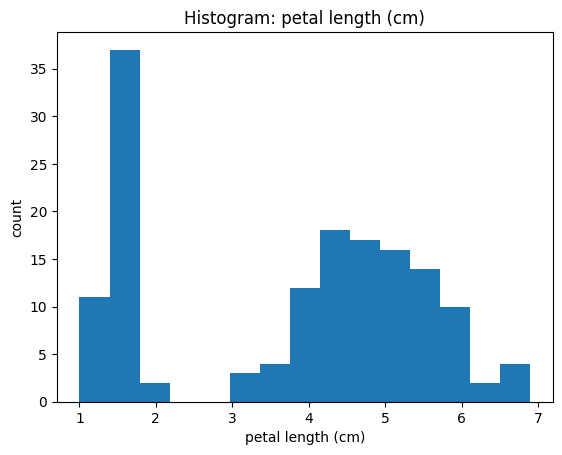

In [ ]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")
target_names = iris.target_names

print("Dimenzije X:", X.shape)
print("Broj instanci po klasi:\n", y.value_counts())


display(X.describe())


display(X.corr().round(3))


plt.figure()
plt.hist(X["petal length (cm)"], bins=15)
plt.title("Histogram: petal length (cm)")
plt.xlabel("petal length (cm)")
plt.ylabel("count")
plt.show()


## Diskusija EDA (konkretne vrednosti)

- Skup podataka ima **150** instanci i **4** numeričke osobine (feature-a).
- Raspodela klasa je ravnomerna: {0: 50, 1: 50, 2: 50} (po **50** uzoraka u svakoj klasi), pa *accuracy* nije “zavaravajuća” metrika u ovom primeru.
- Na osnovu opisne statistike (tabela ispod) vidi se da je npr. **petal length** u opsegu od **1.0** do **6.9** sa prosekom **3.758**.
- Korelaciona matrica pokazuje da su **petal length** i **petal width** vrlo povezani (korelacija ≈ **0.963**), što znači da nose sličnu informaciju i često dobro razdvajaju klase.


## 2. Preprocessing: train/test split + standardizacija

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)  
X_test_s = scaler.transform(X_test)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (120, 4) Test shape: (30, 4)


## Diskusija preprocessing-a (split + scaling)

- Podaci su podeljeni na **train** (80%) i **test** (20%) uz `stratify=y`, tako da odnos klasa ostane isti u oba skupa.
- Skaliranje je urađeno sa **StandardScaler** (standardizacija), jer algoritmi kao što su **KNN** i **logistička regresija** bolje rade kada su osobine na sličnoj skali.
- Važno: scaler je “fitovan” samo na trening skupu (`fit_transform` na train), a na test skupu je primenjen samo `transform`, čime se izbegava **data leakage**.


## 3. Nadgledano učenje: KNN (k=5)

KNN accuracy: 0.9333333333333333

KNN classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30

KNN confusion matrix:
 [[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]


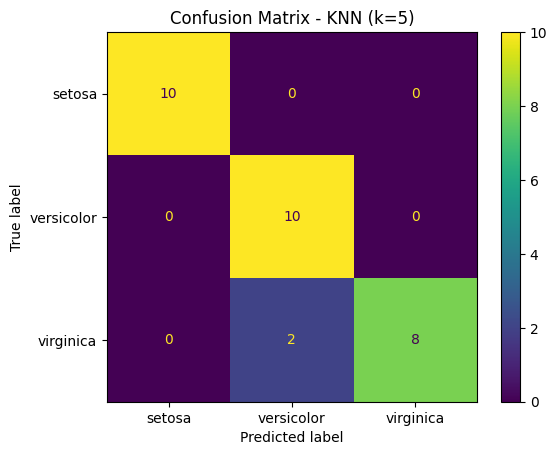

In [4]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train)
pred_knn = knn.predict(X_test_s)

acc_knn = accuracy_score(y_test, pred_knn)
print("KNN accuracy:", acc_knn)

print("\nKNN classification report:\n")
print(classification_report(y_test, pred_knn, target_names=target_names))

cm_knn = confusion_matrix(y_test, pred_knn)
print("KNN confusion matrix:\n", cm_knn)

ConfusionMatrixDisplay(cm_knn, display_labels=target_names).plot()
plt.title("Confusion Matrix - KNN (k=5)")
plt.show()


## Diskusija rezultata: KNN (k=5)

- Dobijena tačnost (*accuracy*) za KNN je **0.933** (od 30 test uzoraka, tačno je klasifikovano 28).
- U KNN confusion matrix jedina greška je što su **2** uzorka klase *virginica* predviđena kao *versicolor* (ćelija [virginica→versicolor] = 2).
- Po klasama (iz `classification_report`):
  - **setosa**: precision=1.000, recall=1.000 → bez grešaka (10/10).
  - **versicolor**: precision=0.833, recall=1.000.
  - **virginica**: precision=1.000, recall=0.800 → recall je niži jer su 2 uzorka “pobegla” u versicolor.

**Zaključak:** KNN dobro radi na Iris podacima, ali najveća konfuzija je između **versicolor** i **virginica**, što je poznato i iz literature (te dve klase su sličnije nego setosa).


## 4. Nadgledano učenje: Logistička regresija

Logistic Regression accuracy: 0.9333333333333333

LR classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

LR confusion matrix:
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


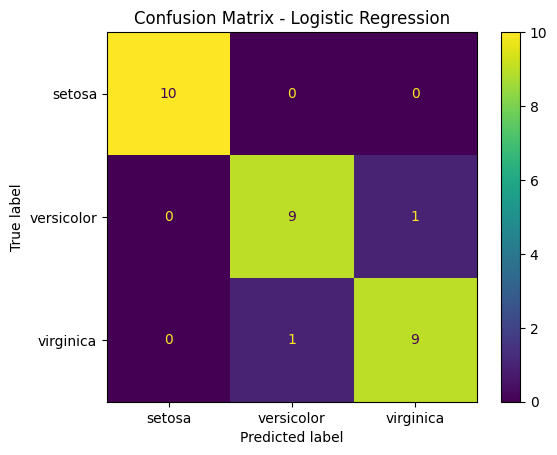

In [5]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_s, y_train)
pred_lr = lr.predict(X_test_s)

acc_lr = accuracy_score(y_test, pred_lr)
print("Logistic Regression accuracy:", acc_lr)

print("\nLR classification report:\n")
print(classification_report(y_test, pred_lr, target_names=target_names))

cm_lr = confusion_matrix(y_test, pred_lr)
print("LR confusion matrix:\n", cm_lr)

ConfusionMatrixDisplay(cm_lr, display_labels=target_names).plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


## Diskusija rezultata: Logistička regresija

- Dobijena tačnost (*accuracy*) za logističku regresiju je **0.933** (takođe 28/30 tačno).
- Kod logističke regresije postoje **2** greške: 1 uzorak *versicolor* je predviđen kao *virginica*, i 1 uzorak *virginica* kao *versicolor*.
- Po klasama:
  - **setosa**: precision=1.000, recall=1.000 → bez grešaka.
  - **versicolor**: precision=0.900, recall=0.900.
  - **virginica**: precision=0.900, recall=0.900.

**Poređenje sa KNN:** oba modela imaju istu accuracy (**0.933**), ali se greške raspoređuju drugačije: KNN pravi 2 greške na *virginica*, dok logistička regresija pravi 1 grešku u oba smera (versicolor↔virginica).


## 5. Uporedni prikaz rezultata

In [6]:
results = pd.DataFrame([
    {"model": "KNN (k=5)", "accuracy": acc_knn},
    {"model": "Logistic Regression", "accuracy": acc_lr},
]).sort_values("accuracy", ascending=False)

display(results)


,model,accuracy
0,KNN (k=5),0.933333
1,Logistic Regression,0.933333


## 6. PCA (redukcija dimenzionalnosti)

Explained variance ratio (PC1, PC2): [0.72962445 0.22850762]
Total explained variance (2D): 0.9581320720000165


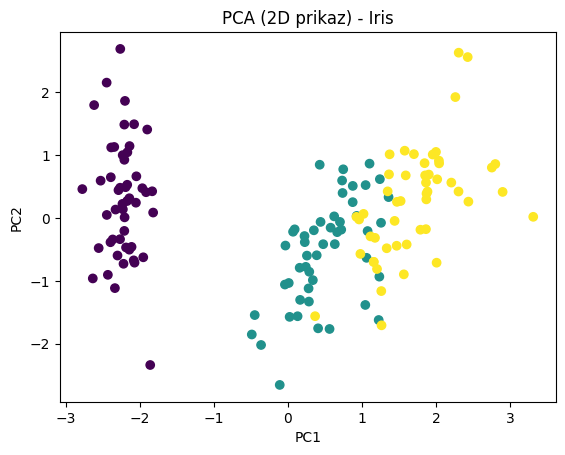

In [ ]:
X_all_s = StandardScaler().fit_transform(X)  
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_all_s)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (2D):", pca.explained_variance_ratio_.sum())

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.title("PCA (2D prikaz) - Iris")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Diskusija PCA (redukcija dimenzionalnosti)

- PCA je primenjen da se 4 osobine svedu na 2 glavne komponente radi vizuelizacije.
- Objašnjena varijansa:
  - PC1 = **0.730**
  - PC2 = **0.229**
  - Zbir (PC1+PC2) = **0.958** → oko **95.8%** ukupne varijanse je objašnjeno sa samo 2 komponente.

**Tumačenje:** Pošto 2 komponente čuvaju ~95.8% informacija, 2D PCA graf je dobar prikaz strukture podataka. U praksi se često vidi da se *setosa* odvaja jasnije, dok se *versicolor* i *virginica* delimično preklapaju — što se poklapa i sa greškama u confusion matrix.


## 7. KMeans klasterizacija (nenadgledano učenje)

Silhouette score: 0.5091683341503112


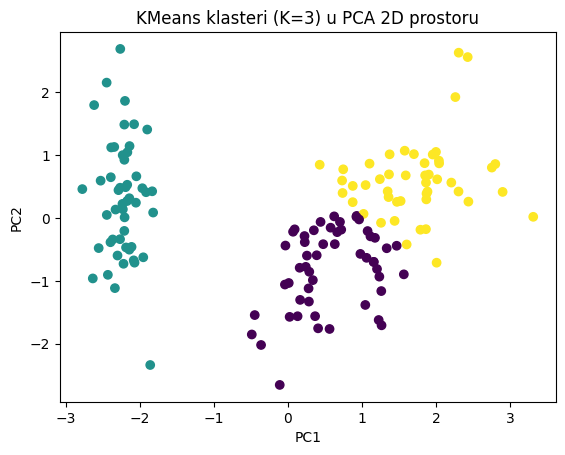

true_class,0,1,2
cluster,,,
0,0,39,14
1,50,0,0
2,0,11,36


In [8]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_pca)

sil = silhouette_score(X_pca, clusters)
print("Silhouette score:", sil)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)
plt.title("KMeans klasteri (K=3) u PCA 2D prostoru")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

ct = pd.crosstab(pd.Series(clusters, name="cluster"), y.rename("true_class"))
display(ct)


## Diskusija KMeans klasterizacije (nenadgledano učenje)

- KMeans je pokrenut sa **K=3** (jer Iris ima 3 klase), ali bez korišćenja label-a.
- Silhouette score je **0.509**.

**Tumačenje silhouette:** Vrednost oko 0.5 ukazuje da klasteri postoje i imaju smisla, ali nisu savršeno odvojeni (što je očekivano jer se versicolor i virginica preklapaju).

**Poređenje klastera sa klasama (crosstab):**
- Jedan klaster se gotovo potpuno poklapa sa klasom *setosa* (u mojim rezultatima cluster 1 sadrži 50/50 setosa).
- Preostala dva klastera dele *versicolor* i *virginica* (npr. cluster 0 ima 39 versicolor i 14 virginica; cluster 2 ima 11 versicolor i 36 virginica).

**Zaključak:** KMeans “prirodno” izdvoji setosu kao zasebnu grupu, dok ostale dve klase nisu potpuno razdvojene, što se vidi i u supervised rezultatima.


## Zaključak

- Na test skupu (30 uzoraka) oba modela su postigla **accuracy = 0.933**:
  - KNN (k=5) ima 2 greške (virginica→versicolor).
  - Logistička regresija ima 2 greške raspoređene u oba smera (versicolor↔virginica).
- PCA sa 2 komponente objašnjava **95.8%** varijanse, pa 2D vizuelizacija verno prikazuje strukturu skupa podataka.
- KMeans na PCA prostoru daje silhouette **0.509**, što potvrđuje da postoje jasni klasteri (posebno setosa), ali da *versicolor* i *virginica* nisu potpuno odvojene.

